In [28]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import seaborn as sns


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'



In [29]:
### load the dirs
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [30]:
### specify the model
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label
    
### create instance of model
nn_model = TripletLabelModel()

In [31]:
### load in validation images and labels
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

## load in the trained model weights and store in a list
model_list = os.listdir(results_dir)
model_list = sorted(model_list)

In [32]:
model_list
### get all items in model_list that begin with 0
m = [i for i in model_list if i.startswith('0')]
m

['0_set_A2_label.pth',
 '0_set_A2_label_and_triplet.pth',
 '0_set_A2_triplet.pth',
 '0_set_A_label.pth',
 '0_set_A_label_and_triplet.pth',
 '0_set_A_triplet.pth',
 '0_set_B_label.pth',
 '0_set_B_label_and_triplet.pth',
 '0_set_B_triplet.pth',
 '0_set_C_label.pth',
 '0_set_C_label_and_triplet.pth',
 '0_set_C_triplet.pth']

# Kushin

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/pytho

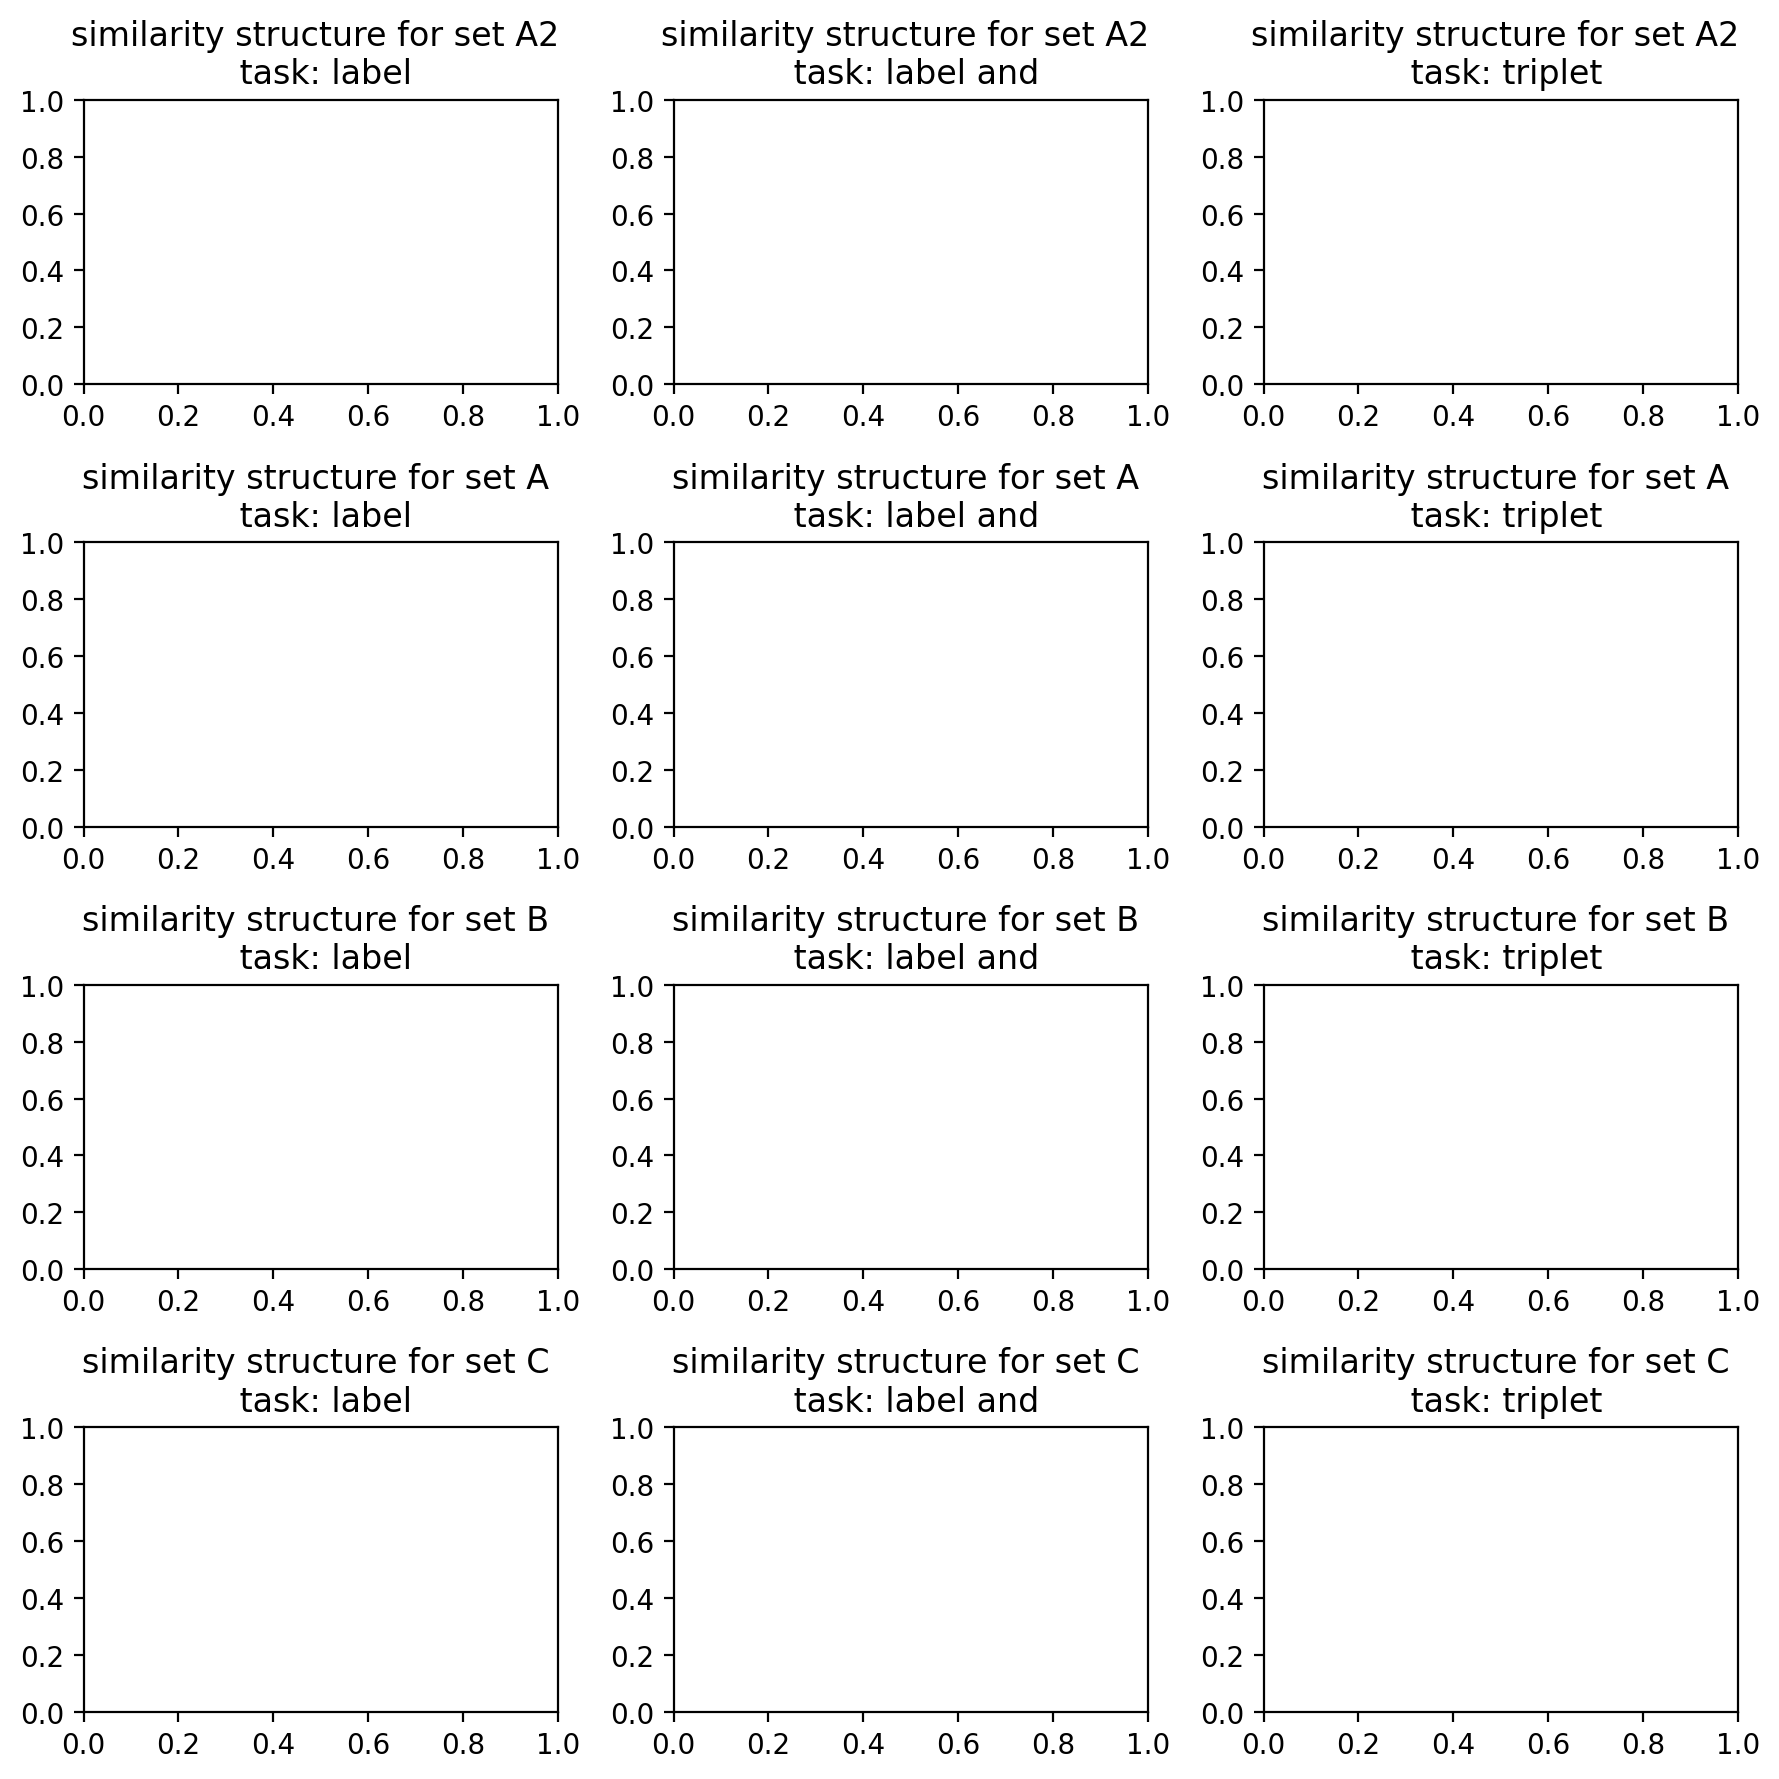

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Re

In [34]:
### load in each model and compute the accuracy on the validation set

nmodels= 10
accs = []
tasks = []
dsets = []
iters = []
cat_scores = []
latents_df =pd.DataFrame(columns=['dataset','task','latent','iter'])
fig, axes = plt.subplots(4,3,figsize=(9,9))

for iter in range(nmodels):
    m_sub = [k for k in model_list if k.startswith(str(iter))]
    for i, this_model in enumerate(m_sub):
        ax = axes.flatten()[i]
        nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
        # nn_model.load_state_dict(torch.load(cifar_model))
        ### pass v_ims through the model but make sure to transpose the image dimensions first
        v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
        v_ims_t = v_ims_t/255.0
        v_ims_t = Resize(32)(v_ims_t)

        ### now pass v_ims through the model
        latents, labels = nn_model(v_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels = torch.argmax(labels,dim=1)
        pred_labels = pred_labels.detach().numpy()

        correct = 0
        for j in range(len(pred_labels)):
            if pred_labels[j] == v_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        accs.append(correct/len(pred_labels))
        tasks.append(this_model.split('_', 3)[3].rsplit('.', 1)[0])
        dsets.append(this_model.split("_")[2])
        iters.append(iter)


        dist = pdist(latents.detach().numpy())
        blocksize = 120
        block_diag = np.zeros((480,480))
        for l in range(4):
            block_diag[l*blocksize:(l+1)*blocksize,l*blocksize:(l+1)*blocksize] = 1

        ### mask distA with block_diag
        within_dist = squareform(dist)*block_diag
        between_dist = squareform(dist)*(1-block_diag)

        categoricality = np.log(np.mean(between_dist)/np.mean(within_dist))
        cat_scores.append(categoricality)


        # Compute pairwise cosine similarities
        cos_sim = cosine_similarity(latents.detach().numpy())

        # # Plot heatmap
        # im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
        # cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        # cbar.set_ticks([-1,0,1])


        # ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
        # ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



        task_string = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


    
        ax.set_title(f'similarity structure for set {this_model.split("_")[2]} \n task: {task_string}')
        

        fig.tight_layout()

        latents_df.loc[(nmodels*i)+iter,'dataset'] = this_model.split("_")[2]
        latents_df.loc[(nmodels*i)+iter,'task'] = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        latents_df.loc[(nmodels*i)+iter,'latent'] = latents.detach().numpy()
        latents_df.loc[(nmodels*i)+iter,'iter'] = iter
        # latents_df.loc[(nmodels*i)+iter,'categoricality'] = categoricality
        

    plt.show()
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs,'dataset':dsets, 'iter':iters,'categoricality':cat_scores})



In [37]:
sns.set_theme(style="white")

In [38]:
acc_df.to_csv(os.path.join(data_dir,'accuracy_data.csv'))

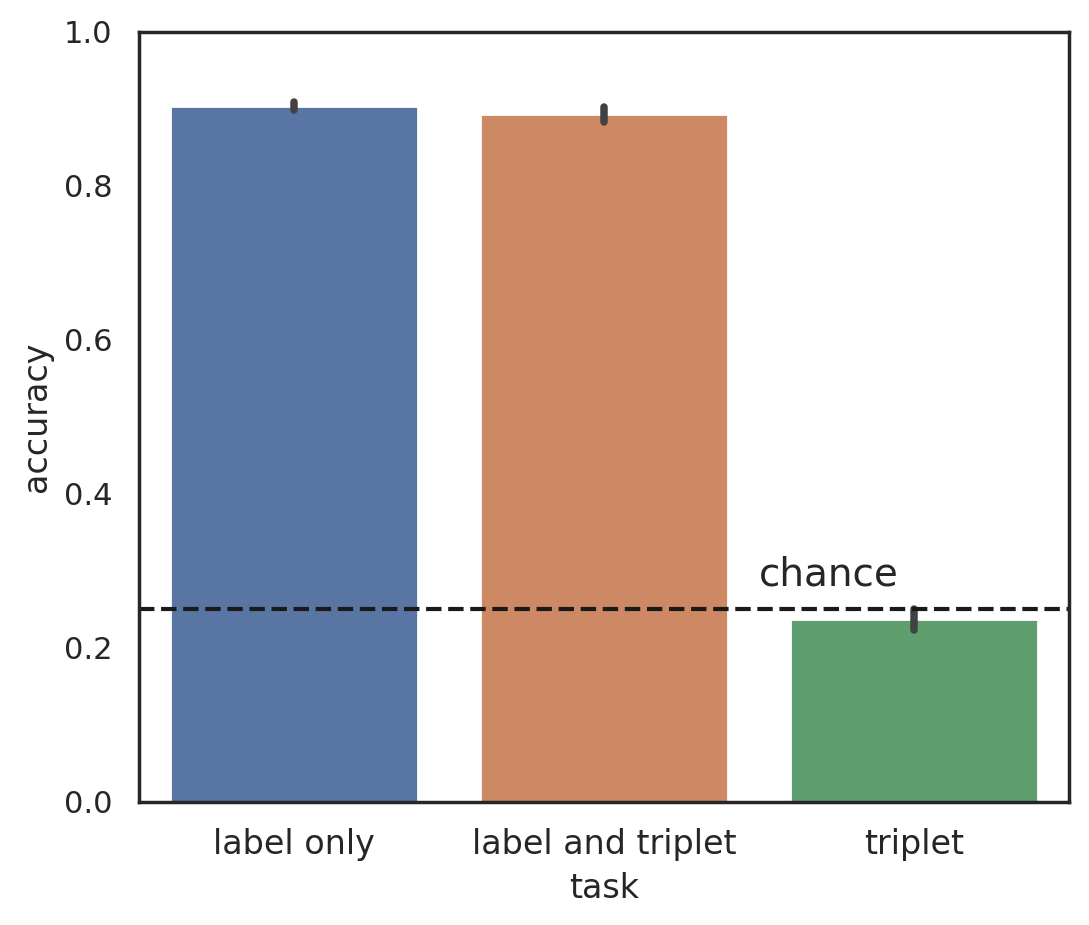

In [39]:
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='accuracy',data=acc_df)
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)

### set the x tick labels to be the task names
plt.xticks(range(3),['label only','label and triplet','triplet'],fontsize=12)
plt.ylim([0,1])
plt.savefig('accuracy_barplot.pdf',dpi=300, bbox_inches='tight')


In [40]:
latents_df['latent'][0].shape

(480, 64)

In [19]:
# latents_df = latents_df[latents_df['task']!='label']
latents_df.head()
# dss.latents


def compute_within_between_procrustes(mat1,mat2, items_per_cat=120):
    within_procrustes = []
    between_procrustes = []
    assert mat1.shape == mat2.shape
    for i in range(int(mat1.shape[0]/items_per_cat)):
        # print('i',i)
        mat1_sub = mat1[i*items_per_cat:(i+1)*items_per_cat,:]
    
        mat2_sub = mat2[i*items_per_cat:(i+1)*items_per_cat,:]
        ### get all the rows in mat2 not in mat2_sub using array indexing

        mat2_sub_c = mat2[np.isin(mat2[:,0],mat2_sub[:,0],invert=True),:]

    
        within_procrustes.append(procrustes(mat1_sub,mat2_sub)[2])
        # print('mat_sub_c shape',mat2_sub_c.shape[0])
        for j in range(int(mat2_sub_c.shape[0]/items_per_cat)):
            # print('j',j)
            this_sub_mat2 = mat2_sub_c[j*items_per_cat:(j+1)*items_per_cat,:]
    
            between_procrustes.append(procrustes(mat1_sub,this_sub_mat2)[2])
            
            # print(procrustes(mat1_sub,this_sub_mat2)[2])
    mean_w_procrustes = np.mean(within_procrustes)
    mean_b_procrustes = np.mean(between_procrustes)
   
    return mean_w_procrustes, mean_b_procrustes
            
    

In [27]:

from scipy.spatial import procrustes

tasks=[]
overlaps = []
withins = []
betweens = []
proc_withins = []
proc_betweens = []
procruses = []
cat_scores_1 = []
cat_scores_2 = []
iters = []
m1s = []
m2s = []
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]
   for this_iter in ds['iter'].unique():
      dss = ds[ds['iter']==this_iter]
      distA = pdist(dss[dss.dataset=='A']['latent'].values[0], metric='cosine')
      distA2 = pdist(dss[dss.dataset=='A2']['latent'].values[0], metric='cosine')
      distB = pdist(dss[dss.dataset=='B']['latent'].values[0], metric='cosine')
      distC = pdist(dss[dss.dataset=='C']['latent'].values[0], metric='cosine')

      blocksize = 120
      block_diag = np.zeros((480,480))
      for i in range(4):
         block_diag[i*blocksize:(i+1)*blocksize,i*blocksize:(i+1)*blocksize] = 1

      ### mask distA with block_diag
      within_distA = squareform(distA)*block_diag
      between_distA = squareform(distA)*(1-block_diag)
      within_distA2 = squareform(distA2)*block_diag
      between_distA2 = squareform(distA2)*(1-block_diag)
      within_distB = squareform(distB)*block_diag
      between_distB = squareform(distB)*(1-block_diag)
      within_distC = squareform(distC)*block_diag
      between_distC = squareform(distC)*(1-block_diag)

      ### compute categoricality measures

      categoricality_A = np.log(np.mean(between_distA)/np.mean(within_distA))
      categoricality_A2 = np.log(np.mean(between_distA2)/np.mean(within_distA2))
      categoricality_B = np.log(np.mean(between_distB)/np.mean(within_distB))
      categoricality_C = np.log(np.mean(between_distC)/ np.mean(within_distC))





      ### compute distance matrices and get lower triangles
      dmatA_within = np.tril(within_distA,k=-1).flatten()
      dmatA2_within = np.tril(within_distA2,k=-1).flatten()
      dmatB_within = np.tril(within_distB,k=-1).flatten()
      dmatC_within = np.tril(within_distC,k=-1).flatten()
   
      dmatA_between = np.tril(between_distA,k=-1).flatten()
      dmatA2_between = np.tril(between_distA2,k=-1).flatten()
      dmatB_between = np.tril(between_distB,k=-1).flatten()
      dmatC_between = np.tril(between_distC,k=-1).flatten()

      ### remove all the zeros from the above 8 vectors 
      dmatA_within = dmatA_within[dmatA_within!=0]
      dmatA2_within = dmatA2_within[dmatA2_within!=0]
      dmatB_within = dmatB_within[dmatB_within!=0]
      dmatC_within = dmatC_within[dmatC_within!=0]
      dmatA_between = dmatA_between[dmatA_between!=0]
      dmatA2_between = dmatA2_between[dmatA2_between!=0]
      dmatB_between = dmatB_between[dmatB_between!=0]
      dmatC_between = dmatC_between[dmatC_between!=0]




      # AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
      # AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
      # BC_sim = np.corrcoef(dmatB,dmatC)[0,1]
      
      AB_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )[2]
      AC_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      BC_proc = procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      AA_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )[2]

      # AB_proc = procrustes(squareform(distA), squareform(distB) )[2]
      # AC_proc = procrustes(squareform(distA), squareform(distC) )[2]
      # BC_proc = procrustes(squareform(distB), squareform(distC) )[2]
      # AA_proc = procrustes(squareform(distA), squareform(distA2) )[2]

      # AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )
      # AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )

      # AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distB) )
      # AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distC) )
      # BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(squareform(distB), squareform(distC) )
      # AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distA2) )
      

   


      AB_within_sim = np.corrcoef(dmatA_within,dmatB_within)[0,1]
      AC_within_sim = np.corrcoef(dmatA_within,dmatC_within)[0,1]
      BC_within_sim = np.corrcoef(dmatB_within,dmatC_within)[0,1]
      AA_within_sim = np.corrcoef(dmatA_within,dmatA2_within)[0,1]

      AB_between_sim = np.corrcoef(dmatA_between,dmatB_between)[0,1]
      AC_between_sim = np.corrcoef(dmatA_between,dmatC_between)[0,1]
      BC_between_sim = np.corrcoef(dmatB_between,dmatC_between)[0,1]
      AA_between_sim = np.corrcoef(dmatA_between,dmatA2_between)[0,1]

      # print(f'{this_task} results')
      # print(f'AA within category similarity for {this_task} is {AA_within_sim}')
      # print(f'AB within category similarity for {this_task} is {AB_within_sim}')
      # print(f'AC within category similarity for {this_task} is {AC_within_sim}')
      # print(f'BC within category similarity for {this_task} is {BC_within_sim}')
      # print('')
      # print(f'AA between category similarity for {this_task} is {AA_between_sim}')
      # print(f'AB between category similarity for {this_task} is {AB_between_sim}')
      # print(f'AC between category similarity for {this_task} is {AC_between_sim}')
      # print(f'BC between category similarity for {this_task} is {BC_between_sim}')
      # print('')
      tasks.append([this_task]*4)
      overlaps.append([50,0,33.33,100])
      withins.append([AB_within_sim,AC_within_sim,BC_within_sim,AA_within_sim])
      betweens.append([AB_between_sim,AC_between_sim,BC_between_sim,AA_between_sim])
      procruses.append([AB_proc,AC_proc,BC_proc,AA_proc])
      # proc_withins.append([AB_proc_within,AC_proc_within,BC_proc_within,AA_proc_within])
      # proc_betweens.append([AB_proc_between,AC_proc_between,BC_proc_between,AA_proc_between])
      cat_scores_1.append([categoricality_A,categoricality_A,categoricality_B,categoricality_A])
      cat_scores_2.append([categoricality_B,categoricality_C,categoricality_C,categoricality_A2])
      iters.append([this_iter]*4)
      m1s.append([f'A{this_iter}',f'A{this_iter}',f'B{this_iter}',f'A{this_iter}'])
      m2s.append([f'B{this_iter}',f'C{this_iter}',f'C{this_iter}',f'A2{this_iter}'])






NameError: name 'latents_df' is not defined

In [21]:
np.corrcoef(dmatA_between,dmatB_between)

array([[1.        , 0.30184513],
       [0.30184513, 1.        ]])

In [22]:
## remove the zeros from dmatA_between and dmatB_between
dmatA_between[dmatA_between==0] = np.nan
dmatB_between[dmatB_between==0] = np.nan
### remove all nans then compute the correlation
np.corrcoef(dmatA_between[~np.isnan(dmatA_between)],dmatB_between[~np.isnan(dmatB_between)])



array([[1.        , 0.30184513],
       [0.30184513, 1.        ]])

In [23]:
sim_df = pd.DataFrame({'m1': np.array(m1s).flatten(),'m2': np.array(m2s).flatten(),\
                        'task':np.array(tasks).flatten(), 'overlap':np.array(overlaps).flatten(),\
                       'within_cat_r':np.array(withins).flatten(),'between_cat_r':np.array(betweens).flatten(), \
                        'procrustes':np.array(procruses).flatten(), \
                        # 'proc_within':np.array(proc_withins).flatten(),'proc_between':np.array(proc_betweens).flatten(),\
                            'cat_score_1':np.array(cat_scores_1).flatten(),\
                             'cat_score_2':np.array(cat_scores_2).flatten(),'iter':np.array(iters).flatten() })
sim_df['mean_cat_score'] = (sim_df['cat_score_1'] + sim_df['cat_score_2'])/2    
# sim_df['procrustes_sim'] = 1/(sim_df['procrustes'])
sim_df['min_cat_score'] = np.min([sim_df['cat_score_1'],sim_df['cat_score_2']],axis=0)
sim_df.to_csv(os.path.join(data_dir,'alignment_data.csv'),index=False)


In [24]:
sim_df

,m1,m2,task,overlap,within_cat_r,between_cat_r,procrustes,cat_score_1,cat_score_2,iter,mean_cat_score,min_cat_score
0,A0,B0,label,50.00,0.325966,0.631553,0.250300,3.145897,3.287757,0,3.216827,3.145897
1,A0,C0,label,0.00,0.244992,0.454759,0.356802,3.145897,2.976447,0,3.061172,2.976447
2,B0,C0,label,33.33,0.285354,0.355558,0.379434,3.287757,2.976447,0,3.132102,2.976447
3,A0,A20,label,100.00,0.661796,0.425021,0.233203,3.145897,2.655586,0,2.900742,2.655586
4,A1,B1,label,50.00,0.370794,0.386929,0.411407,2.705431,3.051460,1,2.878445,2.705431
...,...,...,...,...,...,...,...,...,...,...,...,...
115,A8,A28,triplet,100.00,0.703709,0.648920,0.364869,1.224869,1.234270,8,1.229569,1.224869
116,A9,B9,triplet,50.00,0.327708,0.301845,0.657493,1.203721,1.197750,9,1.200735,1.197750
117,A9,C9,triplet,0.00,0.210690,0.118251,0.848763,1.203721,1.370324,9,1.287022,1.203721
118,B9,C9,triplet,33.33,0.262695,0.148487,0.794566,1.197750,1.370324,9,1.284037,1.197750


In [25]:
sim_df_m1 = sim_df.groupby(['task','m1']).mean().reset_index() 
sim_df_m2 = sim_df.groupby(['task','m2']).mean().reset_index()
## rename m1 and m2 columns to be the same
sim_df_m1 = sim_df_m1.rename(columns={'m1':'model'})
sim_df_m2 = sim_df_m2.rename(columns={'m2':'model'})
## combine sim_df_m1 and sim_df_m2 row-wise
sim_df_m = pd.concat([sim_df_m1,sim_df_m2],axis=0).groupby(['task','model']).mean().reset_index()
sim_df_m.to_csv(os.path.join(data_dir,'alignment_data_avg.csv'),index=False)



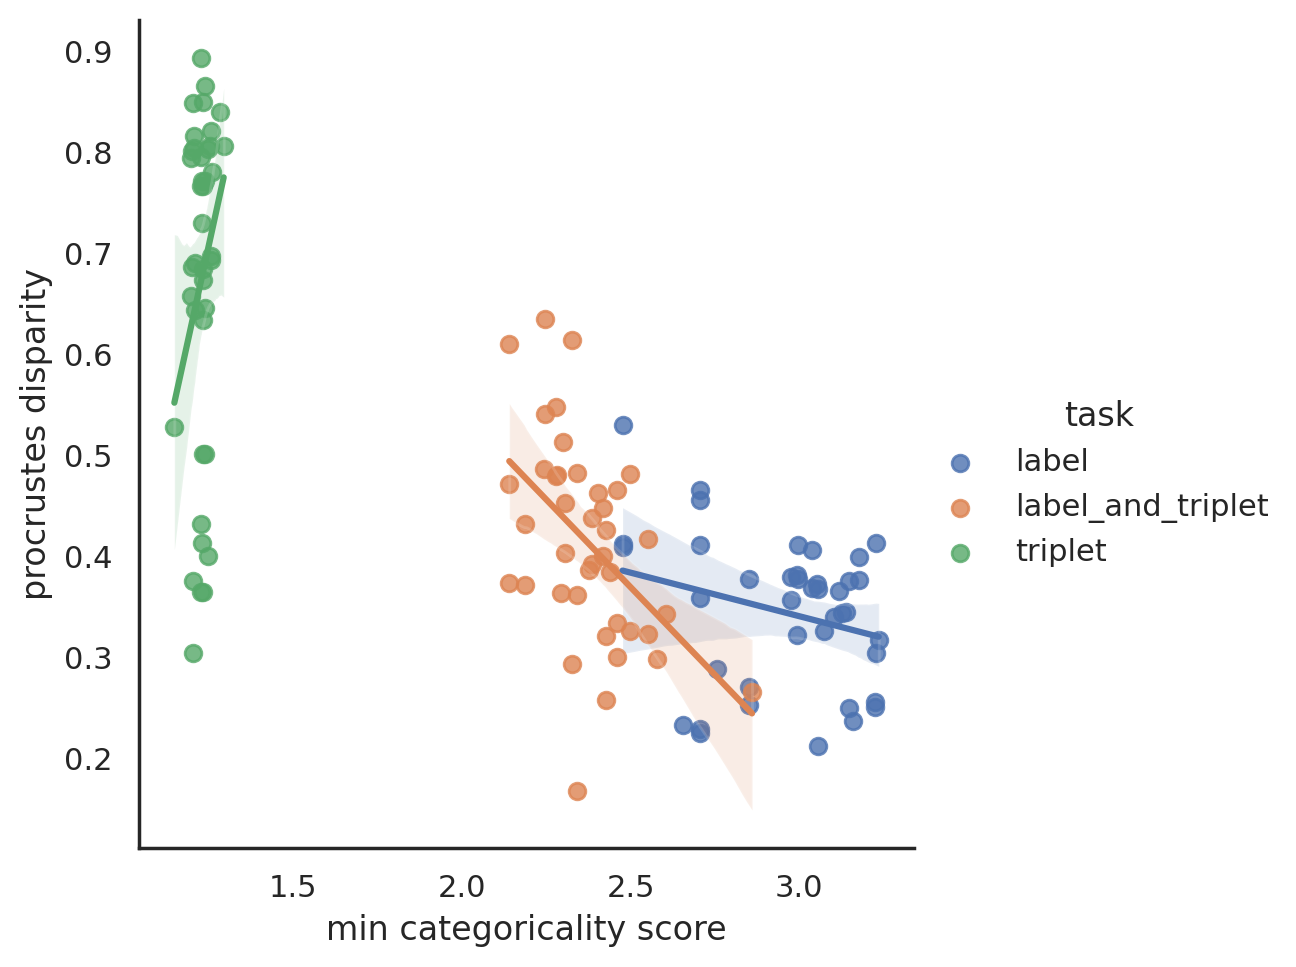

In [26]:
sns.lmplot(x='min_cat_score',y='procrustes',data=sim_df, hue='task',fit_reg=True,legend=True)
# plt.legend(loc='upper left')
plt.xlabel('min categoricality score')
plt.ylabel('procrustes disparity')
plt.savefig('procrustes_vs_cat.pdf',dpi=300, bbox_inches='tight')

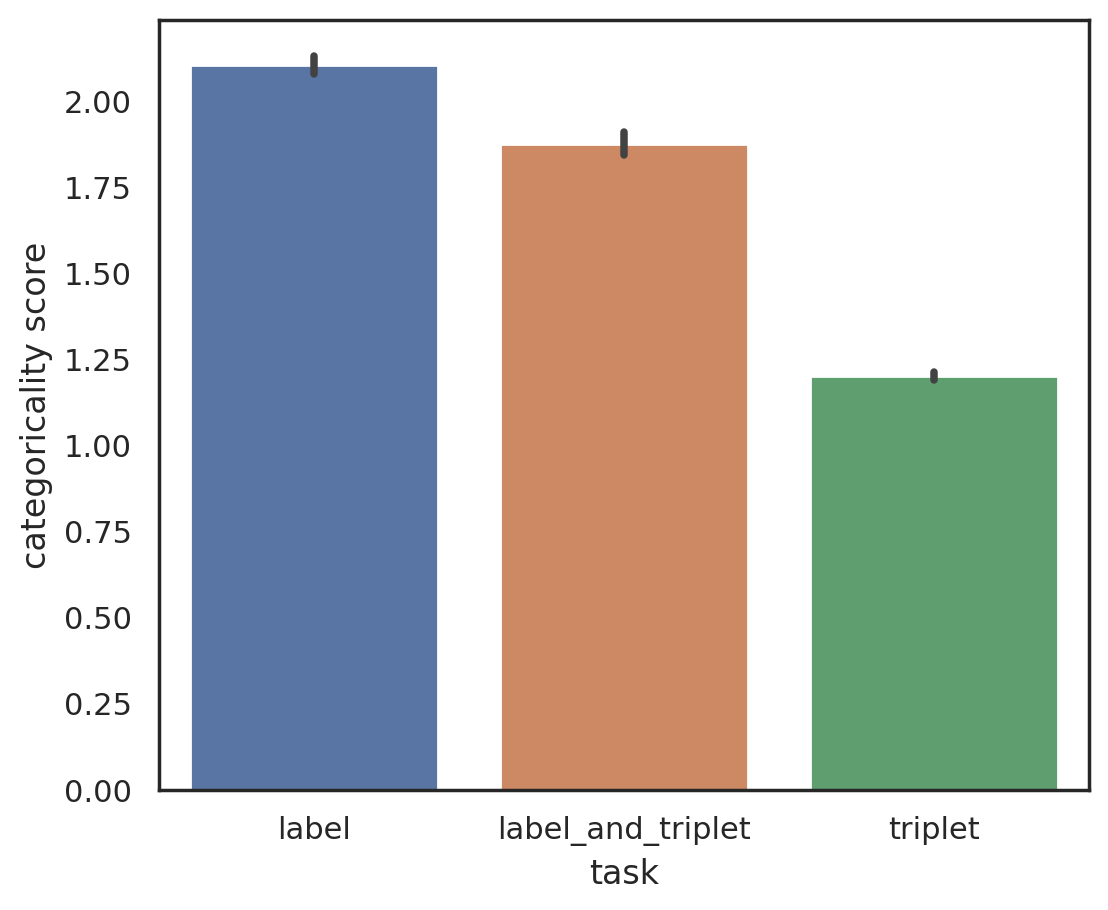

In [27]:
from scipy.stats import pearsonr
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='categoricality',data=acc_df)
plt.ylabel('categoricality score')
plt.xlabel('task')
plt.savefig('categoricality_barplot.pdf',dpi=300, bbox_inches='tight')


In [28]:
acc_df.groupby('task').describe()

accuracy                                                    \
                     count      mean       std       min       25%       50%   
task                                                                           
label                 40.0  0.902865  0.018154  0.866667  0.891146  0.900000   
label_and_triplet     40.0  0.892500  0.029451  0.835417  0.875000  0.891667   
triplet               40.0  0.236927  0.047432  0.143750  0.200000  0.239583   

                                       iter       ...            \
                        75%       max count mean  ...  75%  max   
task                                              ...             
label              0.914583  0.939583  40.0  4.5  ...  7.0  9.0   
label_and_triplet  0.912500  0.977083  40.0  4.5  ...  7.0  9.0   
triplet            0.259896  0.366667  40.0  4.5  ...  7.0  9.0   

                  categoricality                                          \
                           count      mean       std       min       25%   
task                                                                       
label                       40.0  2.105697  0.083867  1.874638  2.068047   
label_and_triplet           40.0  1.874796  0.103970  1.672303  1.801424   
triplet                     40.0  1.200987  0.034445  1.132767  1.179533   

                                                 
                        50%       75%       max  
task                                             
label              2.114263  2.159792  2.248365  
label_and_triplet  1.865207  1.943138  2.148832  
triplet            1.193781  1.209753  1.289118  

[3 rows x 24 columns]

In [29]:
sim_df.groupby('task')['procrustes'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
label,40.0,0.344468,0.074351,0.211819,0.284106,0.361975,0.386448,0.530040
label_and_triplet,40.0,0.413954,0.101526,0.168048,0.340917,0.409983,0.479853,0.635198
triplet,40.0,0.675904,0.166887,0.304027,0.608048,0.713799,0.803409,0.894071


In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

cat_model = ols('procrustes ~ min_cat_score + C(task)', data=sim_df_m).fit()

anova_table = sm.stats.anova_lm(cat_model, typ=2)

cat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             procrustes   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     63.84
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           1.90e-24
Time:                        18:18:02   Log-Likelihood:                 100.30
No. Observations:                 120   AIC:                            -192.6
Df Residuals:                     116   BIC:                            -181.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6892      0.215      3.209      0.002       0.264       1.115
C(task)[T.label_and_triplet]    -0.0024      0.048     -0.049      0.961      -0.098       0.093
C(task)[T.triplet]               0.1048      0.127      0.823      0.412      -0.147       0.357
min_cat_score                   -0.1197      0.073     -1.650      0.102      -0.263       0.024
==============================================================================
Omnibus:                       16.743   Durbin-Watson:                   0.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.477
Skew:                          -0.847   Prob(JB):                     5.90e-05
Kurtosis:                       4.011   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:

sim_df_long = pd.melt(sim_df, id_vars=['task','overlap'], value_vars=['within_cat_r','between_cat_r','procrustes'])

sim_df_long.columns = ['task','overlap','dist_type','alignment']
sim_df_long

,task,overlap,dist_type,alignment
0,label,50.00,within_cat_r,0.325966
1,label,0.00,within_cat_r,0.244992
2,label,33.33,within_cat_r,0.285354
3,label,100.00,within_cat_r,0.661796
4,label,50.00,within_cat_r,0.370794
...,...,...,...,...
355,triplet,100.00,procrustes,0.364869
356,triplet,50.00,procrustes,0.657493
357,triplet,0.00,procrustes,0.848763
358,triplet,33.33,procrustes,0.794566


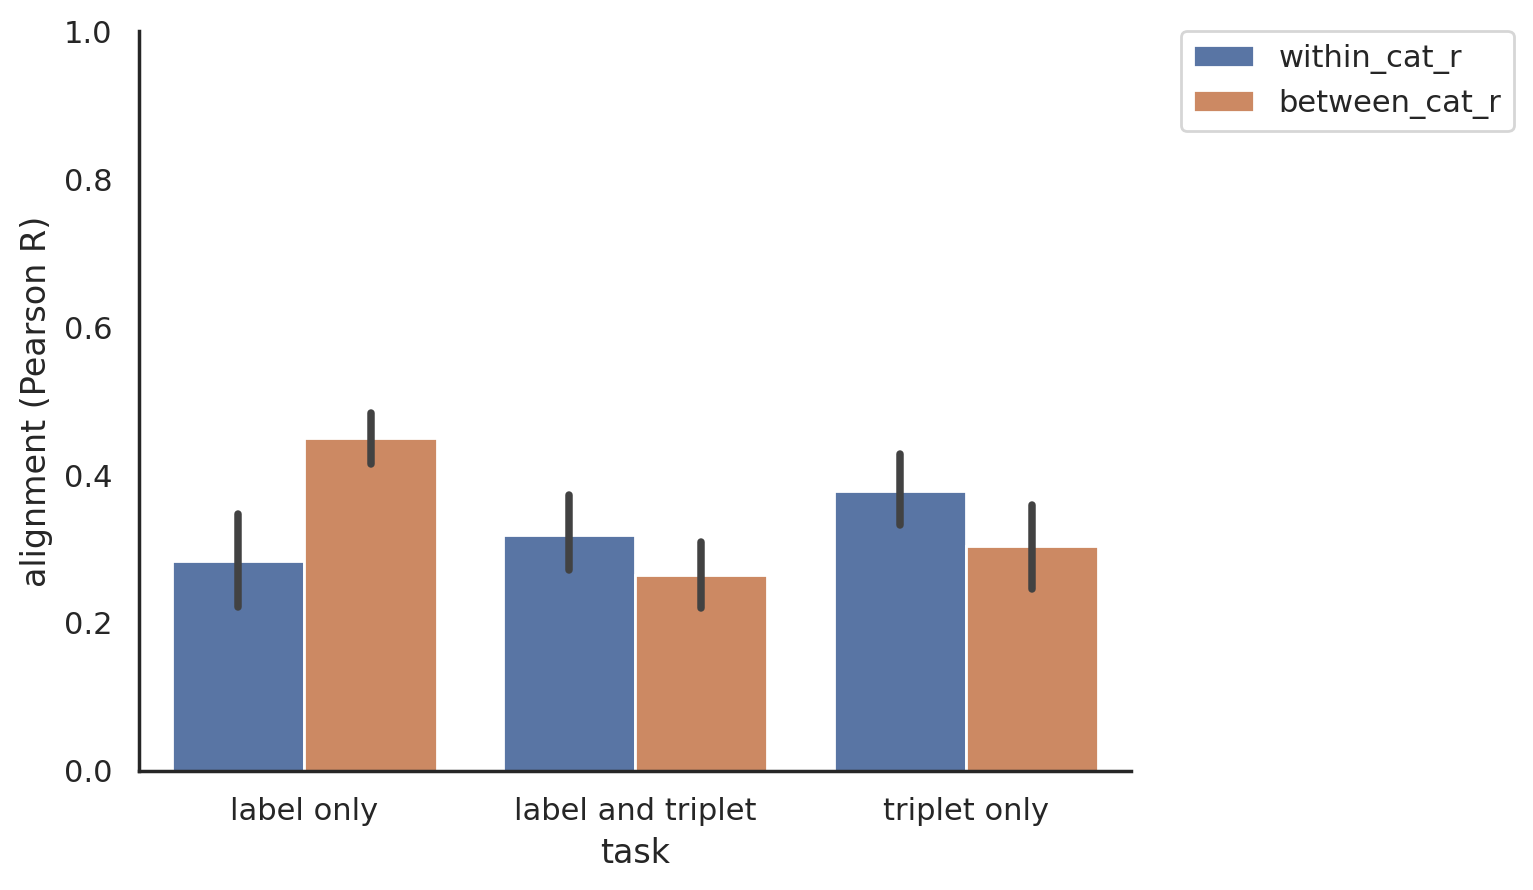

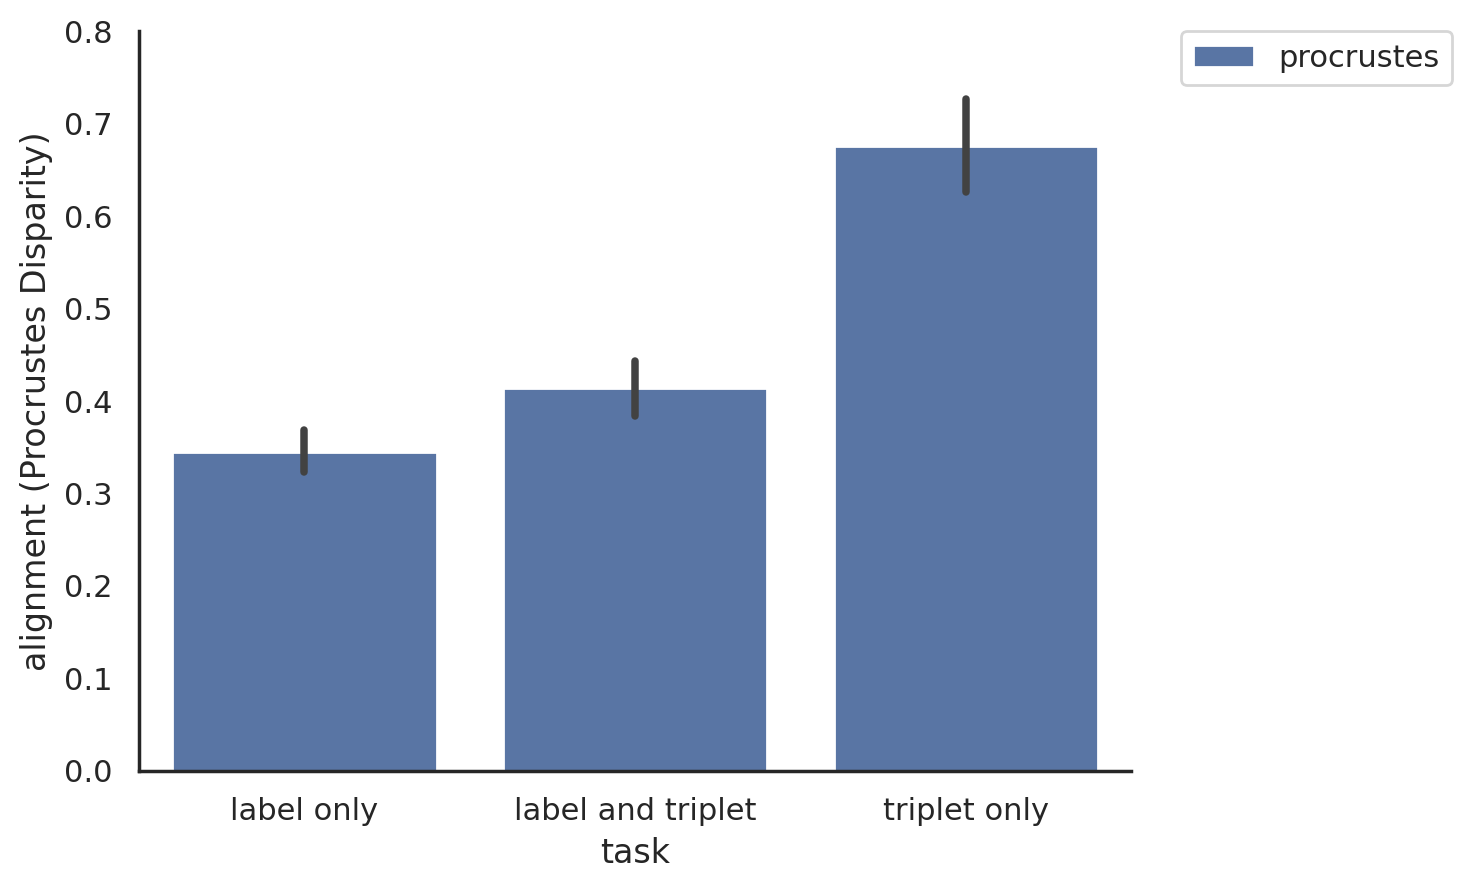

In [33]:

sns.set_theme(style="white")
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['within_cat_r','between_cat_r' ], data=sim_df_long)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Pearson R)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,1])
plt.show()
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['procrustes'], data=sim_df_long)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Procrustes Disparity)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,.8])
plt.savefig('alignment_barplot.pdf',dpi=300, bbox_inches='tight')
# plt.ylim([0,1])
plt.show()

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


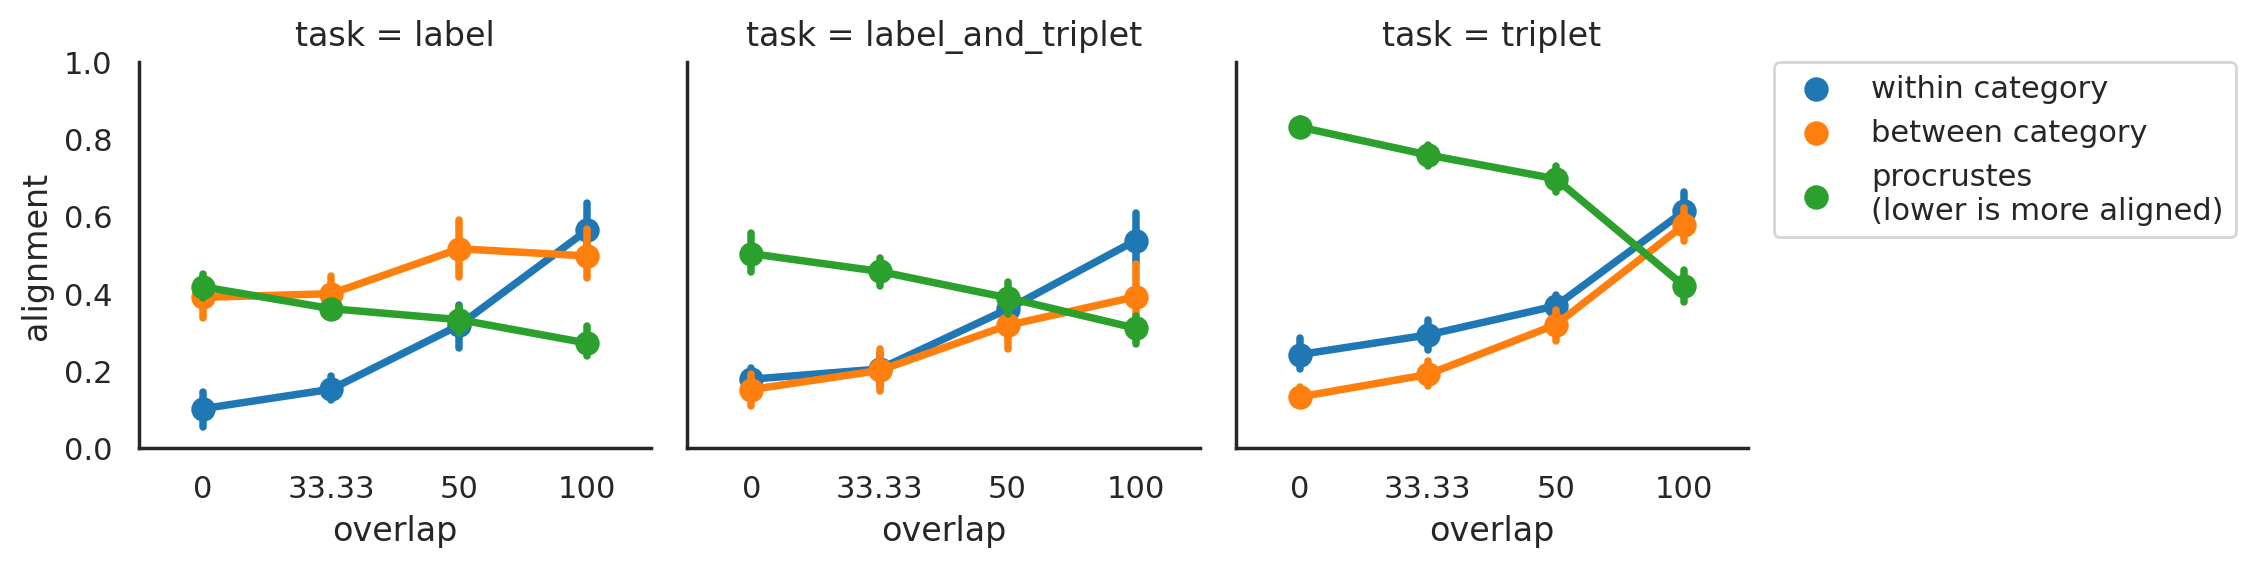

In [34]:
sns.set_theme(style="white")
# sns.pointplot(x="overlap", y="similarity", hue='category', data=sim_df)
# plt.ylim([0,1])
g = sns.FacetGrid(sim_df_long,  col="task", margin_titles=True)
ax= g.map(sns.pointplot, "overlap", "alignment", "dist_type", order=[0,33.33,50,100],palette='tab10')
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
##change the legend labels in l to be more descriptive
l.get_texts()[0].set_text('within category')
l.get_texts()[1].set_text('between category')
l.get_texts()[2].set_text('procrustes\n(lower is more aligned)')

g.set(ylim=(0, 1))


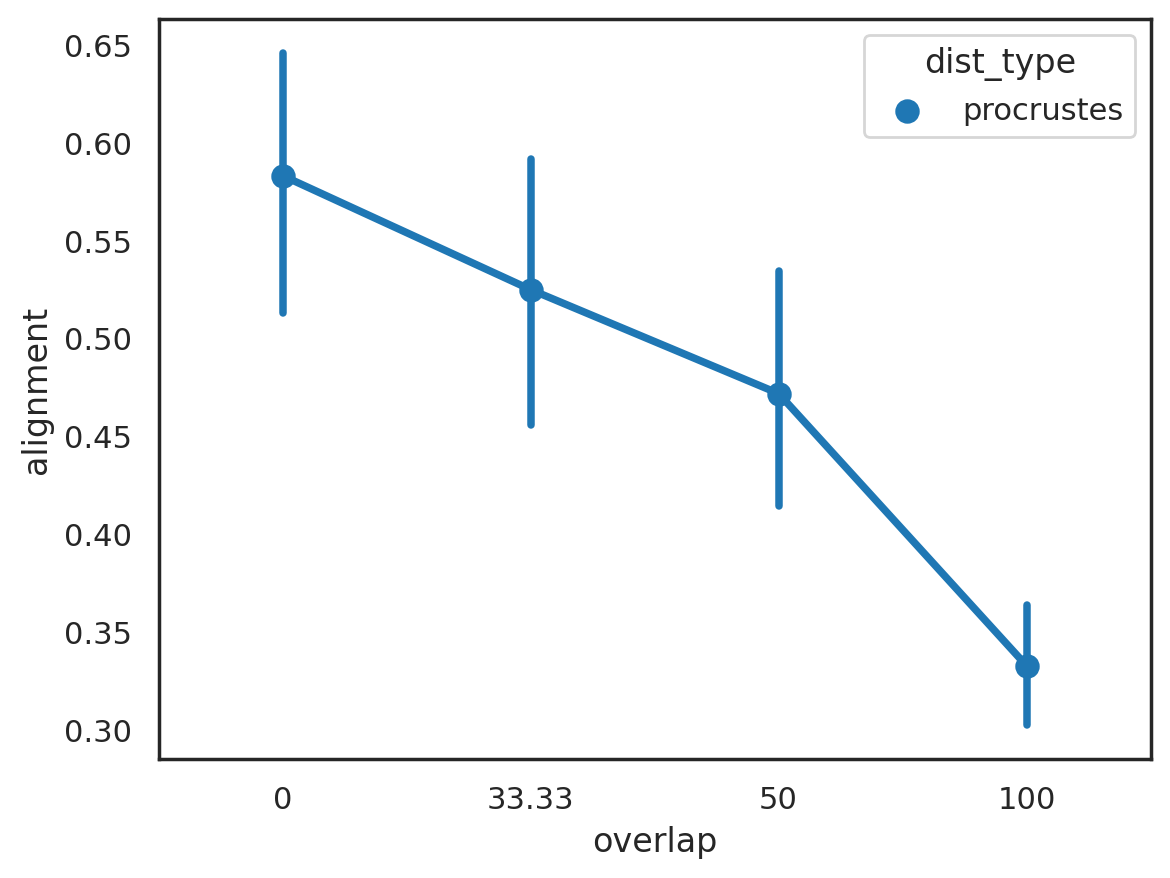

In [35]:
sns.pointplot(data= sim_df_long, x="overlap", y="alignment",hue= "dist_type", hue_order=['procrustes'],order=[0,33.33,50,100],palette='tab10')
plt.savefig('alignment_pointplot.pdf',dpi=300, bbox_inches='tight')

In [36]:
pearsonr([52,212,93,0,0,0,0],[41,5,69,0,0,0,0])

(0.28353456629546475, 0.5377692062081989)

# cross validation accuracy logistic

In [6]:
# ### load in validation images and labels
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

## load in the trained model weights and store in a list
model_list = os.listdir(results_dir)
model_list = sorted(model_list)

In [10]:
### load in each model and compute the accuracy on the validation set
nmodels= 10
accs = []
tasks = []
dsets = []
iters = []
cat_scores = []
latents_df =pd.DataFrame(columns=['dataset','task','latent','iter', 'gt_labels', 'pred_labels'])
# fig, axes = plt.subplots(4,3,figsize=(9,9))

for iter in range(nmodels):
    m_sub = [k for k in model_list if k.startswith(str(iter))]
    for i, this_model in enumerate(m_sub):
        # ax = axes.flatten()[i]
        nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
        
        # v_ims = np.load(os.path.join(data_dir,'set_{}.npy'.format(m_sub[0].split('_set_')[1].split('_')[0][0]))) ## train images
        # v_labels = np.load(os.path.join(data_dir,'set_{}_labs.npy'.format(m_sub[0].split('_set_')[1].split('_')[0][0]))) ## train labs
        v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
        v_ims_t = v_ims_t/255.0
        v_ims_t = Resize(32)(v_ims_t)

        ### now pass v_ims through the model
        latents, labels = nn_model(v_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels = torch.argmax(labels,dim=1)
        pred_labels = pred_labels.detach().numpy()

        correct = 0
        for j in range(len(pred_labels)):
            if pred_labels[j] == v_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        accs.append(correct/len(pred_labels))
        tasks.append(this_model.split('_', 3)[3].rsplit('.', 1)[0])
        dsets.append(this_model.split("_")[2])
        iters.append(iter)


        dist = pdist(latents.detach().numpy())
        blocksize = 120
        block_diag = np.zeros((480,480))
        for l in range(4):
            block_diag[l*blocksize:(l+1)*blocksize,l*blocksize:(l+1)*blocksize] = 1

        ### mask distA with block_diag
        # within_dist = squareform(dist)*block_diag
        # between_dist = squareform(dist)*(1-block_diag)

        # categoricality = np.log(np.mean(between_dist)/np.mean(within_dist))
        # cat_scores.append(categoricality)


        # # Compute pairwise cosine similarities
        # cos_sim = cosine_similarity(latents.detach().numpy())

        # # # Plot heatmap
        # # im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
        # # cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        # # cbar.set_ticks([-1,0,1])


        # # ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
        # # ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



        task_string = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


    
        # ax.set_title(f'similarity structure for set {this_model.split("_")[2]} \n task: {task_string}')
        

        # fig.tight_layout()

        latents_df.loc[(nmodels*i)+iter,'dataset'] = this_model.split("_")[2]
        latents_df.loc[(nmodels*i)+iter,'task'] = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        latents_df.loc[(nmodels*i)+iter,'latent'] = latents.detach().numpy()
        latents_df.loc[(nmodels*i)+iter,'iter'] = iter
        latents_df.loc[(nmodels*i)+iter,'gt_labels'] = v_labels
        latents_df.loc[(nmodels*i)+iter,'pred_labels'] = pred_labels
        
        # latents_df.loc[(nmodels*i)+iter,'categoricality'] = categoricality
        

    # plt.show()
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs,'dataset':dsets, 'iter':iters})



/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [11]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
result_df = pd.DataFrame(columns=['task','dataset','iter','mean_held_out_acc'])

# iterate through each of the rows of latents_df 
# fit a logistic regression model to predict gt_labels from the latent
# use 5 fold cross validation to get the mean held out accuracy
# store the mean held out accuracy in a dataframe

for i in range(len(latents_df)):
    latents = latents_df['latent'][i]
    gt_labels = latents_df['gt_labels'][i]
    # shuffle the latents and gt_labels in the same way
    p = np.random.permutation(len(gt_labels))
    latents = latents[p]
    gt_labels = gt_labels[p]
    # do a 5 fold cross validation and get the mean held out accuracy for logistic regression
    # x is the latents and y is the gt_labels
    kf = KFold(n_splits=5)
    accs = []
    for train_index, test_index in kf.split(latents):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = latents[train_index], latents[test_index]
        y_train, y_test = gt_labels[train_index], gt_labels[test_index]
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        accs.append(clf.score(X_test,y_test))
    result_df.loc[i,'task'] = latents_df['task'][i]
    result_df.loc[i,'dataset'] = latents_df['dataset'][i]
    result_df.loc[i,'iter'] = latents_df['iter'][i]
    result_df.loc[i,'mean_held_out_acc'] = float(np.mean(accs))

    

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

In [12]:
result_df['mean_held_out_acc'] = pd.to_numeric(result_df['mean_held_out_acc'], errors='coerce')



In [19]:
result_df.groupby('task').std()

,mean_held_out_acc
task,
label,0.014624
label_and_triplet,0.018462
triplet,0.052909


In [20]:
result_df.groupby('task').mean()

,mean_held_out_acc
task,
label,0.933698
label_and_triplet,0.940260
triplet,0.700990


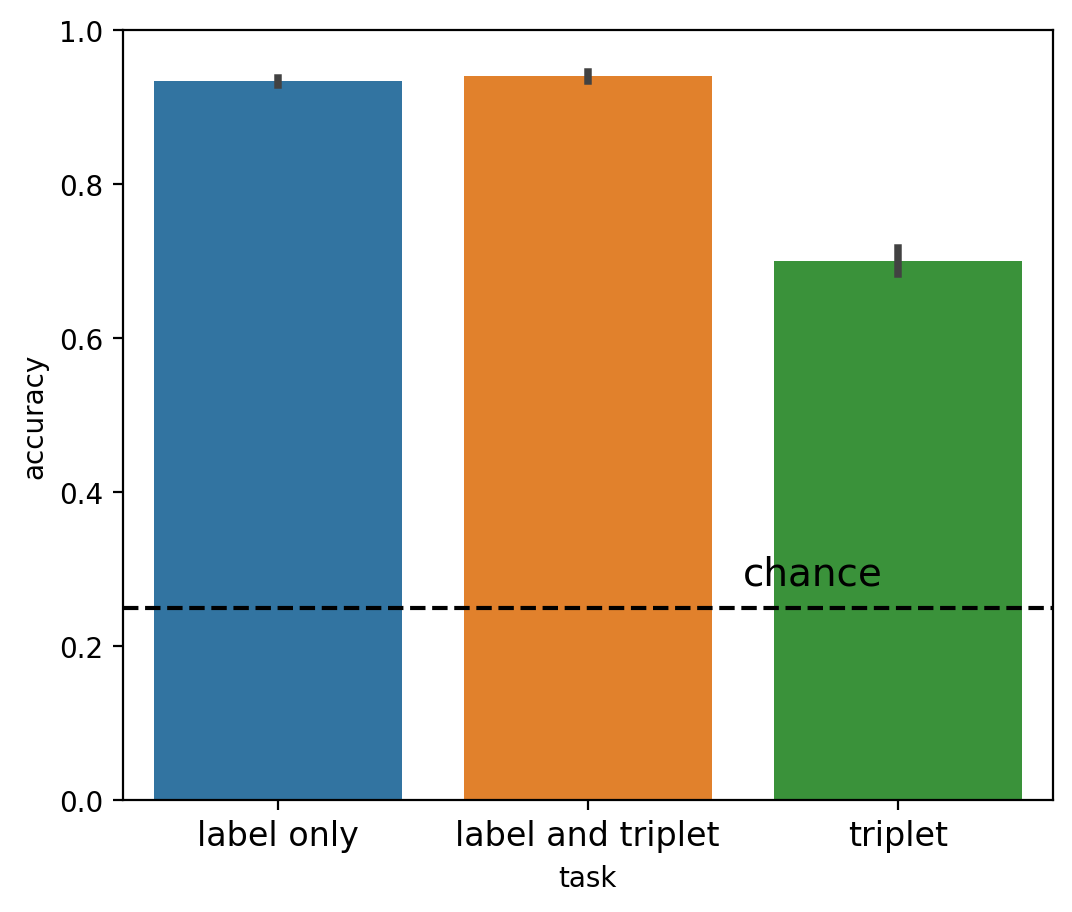

In [18]:
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='mean_held_out_acc',data=result_df)
plt.ylabel('accuracy')
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)

### set the x tick labels to be the task names
plt.xticks(range(3),['label only','label and triplet','triplet'],fontsize=12)
plt.ylim([0,1])
plt.savefig('cv_accuracy_barplot.pdf',dpi=300, bbox_inches='tight')


# Accuracy measeure based on mean categorical reprsentations

In [45]:
### load in each model and compute the accuracy on the validation set
nmodels= 10
accs_train = []
accs_val = []
tasks = []
dsets = []
iters = []
cat_scores = []
latents_train_df =pd.DataFrame(columns=['dataset','task', 'iter', 'latent_train', 'gt_labels_train', 'pred_labels_train', 'latent_val', 'gt_labels_val', 'pred_labels_val'])
# fig, axes = plt.subplots(4,3,figsize=(9,9))

for iter in range(nmodels):
    m_sub = [k for k in model_list if k.startswith(str(iter))]
    for i, this_model in enumerate(m_sub):
        # ax = axes.flatten()[i]
        nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
        print(this_model, data_dir,'set_{}.npy'.format(m_sub[i].split('_set_')[1].split('_')[0][0]))
        train_imgs = np.load(os.path.join(data_dir,'set_{}.npy'.format(m_sub[0].split('_set_')[1].split('_')[0][0]))) ## train images
        train_labels = np.load(os.path.join(data_dir,'set_{}_labs.npy'.format(m_sub[0].split('_set_')[1].split('_')[0][0]))) ## train labs
        train_ims_t = torch.from_numpy(train_imgs.transpose(0,3,1,2)).float()
        train_ims_t = train_ims_t/255.0
        train_ims_t = Resize(32)(train_ims_t)

        ### now pass v_ims through the model
        latents_train, labels_train = nn_model(train_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels_train = torch.argmax(labels_train,dim=1)
        pred_labels_train = pred_labels_train.detach().numpy()

        correct = 0
        for j in range(len(pred_labels_train)):
            if pred_labels_train[j] == train_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        accs_train = correct/len(pred_labels_train)
        tasks.append(this_model.split('_', 3)[3].rsplit('.', 1)[0])
        dsets.append(this_model.split("_")[2])
        iters.append(iter)



        val_imgs = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
        val_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels
        val_ims_t = torch.from_numpy(val_imgs.transpose(0,3,1,2)).float()
        val_ims_t = val_ims_t/255.0
        val_ims_t = Resize(32)(val_ims_t)
        
        ### now pass v_ims through the model
        latents_val, labels_val = nn_model(val_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels_val = torch.argmax(labels_val,dim=1)
        pred_labels_val = pred_labels_val.detach().numpy()
        
        correct = 0
        for j in range(len(pred_labels_val)):
            if pred_labels_val[j] == val_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        
        accs_val = (correct/len(pred_labels_val))
        
        
        
        # dist = pdist(latents.detach().numpy())
        # blocksize = 120
        # block_diag = np.zeros((480,480))
        # for l in range(4):
        #     block_diag[l*blocksize:(l+1)*blocksize,l*blocksize:(l+1)*blocksize] = 1

        ### mask distA with block_diag
        # within_dist = squareform(dist)*block_diag
        # between_dist = squareform(dist)*(1-block_diag)

        # categoricality = np.log(np.mean(between_dist)/np.mean(within_dist))
        # cat_scores.append(categoricality)


        # # Compute pairwise cosine similarities
        # cos_sim = cosine_similarity(latents.detach().numpy())

        # # # Plot heatmap
        # # im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
        # # cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        # # cbar.set_ticks([-1,0,1])


        # # ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
        # # ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



        task_string = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')

    
        # ax.set_title(f'similarity structure for set {this_model.split("_")[2]} \n task: {task_string}')
        

        # fig.tight_layout()

        latents_train_df.at[(nmodels*i)+iter,'dataset'] = this_model.split("_")[2]
        latents_train_df.at[(nmodels*i)+iter,'task'] = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        latents_train_df.at[(nmodels*i)+iter,'latent_train'] = latents_train.detach().numpy()
        latents_train_df.at[(nmodels*i)+iter,'iter'] = iter
        latents_train_df.at[(nmodels*i)+iter,'latent_val'] = latents_val.detach().numpy()
        latents_train_df.at[(nmodels*i)+iter,'gt_labels_train'] = train_labels
        latents_train_df.at[(nmodels*i)+iter,'gt_labels_val'] = val_labels
        latents_train_df.at[(nmodels*i)+iter,'pred_labels_train'] = pred_labels_train
        latents_train_df.at[(nmodels*i)+iter,'pred_labels_val'] = pred_labels_val
        latents_train_df.at[(nmodels*i)+iter,'acc_train'] = accs_train
        latents_train_df.at[(nmodels*i)+iter,'acc_val'] = accs_val

        


0_set_A2_label.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_A2_label_and_triplet.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_A2_triplet.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_A_label.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_A_label_and_triplet.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_A_triplet.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_A.npy
0_set_B_label.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_B.npy
0_set_B_label_and_triplet.pth /mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/data set_B.npy
0_set_B_triplet.pth /mnt/dv/w

In [46]:
accs_train

0.26666666666666666

In [47]:
latents_train_df

,dataset,task,iter,latent_train,gt_labels_train,pred_labels_train,latent_val,gt_labels_val,pred_labels_val,acc_train,acc_val
0,A2,label,0,"[[0.09513201, 3.1898658, 1.4254017, 0.7653076,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0, 0, 0, 0, 1, ...","[[-0.22193965, 2.2494857, 0.7884193, 1.3341671...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, ...",0.887083,0.875000
10,A2,label_and_triplet,0,"[[-0.95914847, -0.7744454, -0.022755206, 0.964...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 0, 0, 3, ...","[[-0.2783456, -0.28118914, 0.21440709, 0.13175...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 1, 1, 1, ...",0.910417,0.916667
20,A2,triplet,0,"[[-3.067784, 1.2641057, 0.8021932, 0.43552306,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-2.346183, -0.20968887, 0.7601117, 1.1399823...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, ...",0.219583,0.191667
30,A,label,0,"[[4.3222733, 2.1915526, 0.55696017, -0.3516666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[[1.8412822, 1.4406773, 0.45024672, 0.41042143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...",0.918333,0.922917
40,A,label_and_triplet,0,"[[2.1082911, 1.7748388, 0.68828994, -0.6833313...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, ...","[[1.404073, 0.2502705, 0.1085603, 0.15025234, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...",0.867083,0.858333
...,...,...,...,...,...,...,...,...,...,...,...
79,B,label_and_triplet,9,"[[0.82551885, 1.0757159, -1.4933159, -0.551461...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 3, ...","[[0.5706377, 0.727687, -0.09106047, -0.0228841...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, ...",0.882917,0.860417
89,B,triplet,9,"[[2.1764011, -2.7034147, 1.3282374, 0.03291325...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1.6877228, -2.521443, 0.78480905, -0.1197740...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.247500,0.245833
99,C,label,9,"[[0.269135, 1.0142447, 2.1816492, -0.26193464,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.26072428, 0.2508365, 1.5580432, 0.11557138...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...",0.918333,0.916667
109,C,label_and_triplet,9,"[[-0.2855235, 2.790575, 0.97003746, -0.0652740...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.9788429, 1.1313941, 0.27509797, 0.8350977...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.869583,0.845833


In [52]:
# iterate through each of the rows of latents_df
# look at the'latent' column, and the 'gt_labels' column, and find the mean latent for each gt_label. Add this to the same dataframe. add 4 rows for each model, one average latent for each gt_label
mean_0 = []
mean_1 = []
mean_2 = []
mean_3 = []
for i in range(len(latents_train_df)):
    latents = latents_train_df['latent_train'][i]
    gt_labels = latents_train_df['gt_labels_train'][i]
    idx_0 = np.where(gt_labels==0)[0]
    idx_1 = np.where(gt_labels==1)[0]
    idx_2 = np.where(gt_labels==2)[0]
    idx_3 = np.where(gt_labels==3)[0]
    mean_latent_0 = np.mean(latents[idx_0],axis=0)
    mean_latent_1 = np.mean(latents[idx_1],axis=0)
    mean_latent_2 = np.mean(latents[idx_2],axis=0)
    mean_latent_3 = np.mean(latents[idx_3],axis=0)
    mean_0.append(mean_latent_0)
    mean_1.append(mean_latent_1)
    mean_2.append(mean_latent_2)
    mean_3.append(mean_latent_3)

latents_train_df['mean_latent_0'] = mean_0
latents_train_df['mean_latent_1'] = mean_1
latents_train_df['mean_latent_2'] = mean_2
latents_train_df['mean_latent_3'] = mean_3



(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


In [49]:
latents_train_df

,dataset,task,iter,latent_train,gt_labels_train,pred_labels_train,latent_val,gt_labels_val,pred_labels_val,acc_train,acc_val,mean_latent_0,mean_latent_1,mean_latent_2,mean_latent_3
0,A2,label,0,"[[0.09513201, 3.1898658, 1.4254017, 0.7653076,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0, 0, 0, 0, 1, ...","[[-0.22193965, 2.2494857, 0.7884193, 1.3341671...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, ...",0.887083,0.875000,"[1.9273307, 3.0625534, 1.1256586, -0.7003977, ...","[-0.4575704, 3.8234868, 2.0298698, 1.3783385, ...","[-0.27831197, 2.1316226, -0.20583118, 2.741525...","[0.8222773, 2.1273472, 0.96388954, 2.029502, 0..."
10,A2,label_and_triplet,0,"[[-0.95914847, -0.7744454, -0.022755206, 0.964...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 0, 0, 3, ...","[[-0.2783456, -0.28118914, 0.21440709, 0.13175...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 1, 1, 1, ...",0.910417,0.916667,"[0.48925963, 2.7337909, 1.1462272, 0.46369043,...","[-1.0788201, 2.569827, -1.0304403, 1.65588, -1...","[3.6885107, 3.2684736, 1.4351119, -0.20634204,...","[3.5688908, 1.6808897, 1.4762728, -1.305855, -..."
20,A2,triplet,0,"[[-3.067784, 1.2641057, 0.8021932, 0.43552306,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-2.346183, -0.20968887, 0.7601117, 1.1399823...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, ...",0.219583,0.191667,"[2.4724464, 2.080318, 1.1647029, -0.9986789, 0...","[2.67403, 2.6402502, 0.69276786, -0.167563, -0...","[0.91151947, 2.416563, 1.1476476, 1.3220674, -...","[-1.8876026, 1.6645625, -1.2181245, 2.4109004,..."
30,A,label,0,"[[4.3222733, 2.1915526, 0.55696017, -0.3516666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[[1.8412822, 1.4406773, 0.45024672, 0.41042143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...",0.918333,0.922917,"[1.1006007, 1.7513312, 2.1199446, 0.8231765, -...","[-0.81817734, 2.0267253, 2.7817504, 0.89236695...","[-0.15435806, 3.144471, 1.9943886, 2.2431095, ...","[0.343828, 1.266787, -0.7034191, 1.9095074, -1..."
40,A,label_and_triplet,0,"[[2.1082911, 1.7748388, 0.68828994, -0.6833313...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, ...","[[1.404073, 0.2502705, 0.1085603, 0.15025234, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...",0.867083,0.858333,"[3.1479201, 1.8728139, 0.31763402, -0.40109262...","[0.30419022, 1.1918617, 1.7750838, -0.53652483...","[-0.6266804, -1.106301, 0.49047515, 0.5290817,...","[2.95065, 0.2281206, 1.6681609, -1.1074904, 1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,B,label_and_triplet,9,"[[0.82551885, 1.0757159, -1.4933159, -0.551461...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 3, ...","[[0.5706377, 0.727687, -0.09106047, -0.0228841...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, ...",0.882917,0.860417,"[-0.6555483, 0.09816017, 0.26890188, -0.201277...","[-0.5154852, 0.14355612, 0.31524304, -0.127760...","[-0.4355781, -0.08524644, -0.28369024, -0.0489...","[1.9260286, -0.4663022, -0.17760904, 0.0938590..."
89,B,triplet,9,"[[2.1764011, -2.7034147, 1.3282374, 0.03291325...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1.6877228, -2.521443, 0.78480905, -0.1197740...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.247500,0.245833,"[-0.15084375, 0.3143716, -0.24931239, -0.30009...","[0.11990566

In [50]:
new_analysis_pred_labels = []
new_analysis_accs = []
for i in range(len(latents_train_df)):
    category_closeness_pred_labels = []
    category_closess_accs = []
    latents = latents_train_df['latent_val'][i]
    gt_labels = latents_train_df['gt_labels_val'][i]
    dataset = latents_train_df['dataset'][i]
    task = latents_train_df['task'][i]
    iter = latents_train_df['iter'][i]
    mean_latent_0 = latents_train_df['mean_latent_0'][i]
    mean_latent_1 = latents_train_df['mean_latent_1'][i]
    mean_latent_2 = latents_train_df['mean_latent_2'][i]
    mean_latent_3 = latents_train_df['mean_latent_3'][i]
    for j in range(len(latents)):
        latent = latents[j]
        dist_0 = cosine_similarity(latent.reshape(1,-1),mean_latent_0.reshape(1,-1))
        dist_1 = cosine_similarity(latent.reshape(1,-1),mean_latent_1.reshape(1,-1))
        dist_2 = cosine_similarity(latent.reshape(1,-1),mean_latent_2.reshape(1,-1))
        dist_3 = cosine_similarity(latent.reshape(1,-1),mean_latent_3.reshape(1,-1))
        dists = [dist_0,dist_1,dist_2,dist_3]
        category_closeness_pred_labels.append(np.argmax(dists))
        if np.argmax(dists) == gt_labels[j]:
            category_closess_accs.append(1)
        else:
            category_closess_accs.append(0)
    new_analysis_accs.append(np.mean(category_closess_accs)) 
    new_analysis_pred_labels.append(category_closeness_pred_labels)
latents_train_df['pred_new_analysis_pred_labels'] = new_analysis_pred_labels
latents_train_df['new_analysis_accs'] = new_analysis_accs

    

In [51]:
latents_train_df.groupby('task').mean()

,acc_train,acc_val,new_analysis_accs
task,,,
label,0.903896,0.902865,0.318229
label_and_triplet,0.895156,0.892500,0.332969
triplet,0.239313,0.236927,0.344583
